# Mini-Project: SVM & LR Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<span style="color: blue">Remove all blue text before submitting</span>

In [1]:
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics as mt

### Supporting Functions

In [2]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    temp = scaler.fit(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [3]:
verboseStatus = False

In [4]:
# Brett's directory
# Desktop
# %cd "C:\Sandbox\SMU\dataMining\ChoRepo\EducationDataNC\2017\Machine Learning Datasets"
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory. Either uncomment the cd statement above or make your own cd.
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directorY 
#%cd "C:\Users\Nicole Wittlin\Documents\7331DataMining\EducationDataNC\2017\Raw Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

print('********* Initial Values Before Cleaning *******************')
dfPublicHS.info(verbose = verboseStatus)

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets
********* Initial Values Before Cleaning *******************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 403 entries, student_num to unit_code
dtypes: float64(322), int64(81)
memory usage: 1.4 MB


In [5]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

Columns Dropped: 1


In [6]:
# Create correlation matrix
dfCorr = dfPublicHS.corr('pearson').abs()

In [7]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop Columns
dfDropped = dfPublicHS.drop(columns = to_drop, axis = 1)

print("Columns dropped: {}".format(len(to_drop)))

Columns dropped: 124


In [8]:
# Split the target variable based on the median value
medianSplit = dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].median()

dfDropped['schoolPctTarget'] = np.where(dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= medianSplit, 1, 0)

print("Median: {}".format(medianSplit))
print("{} of {}: {}%".format(dfDropped['schoolPctTarget'].sum(), dfDropped.shape[0], 
                             round(dfDropped['schoolPctTarget'].sum()/dfDropped.shape[0] * 100,2)))

Median: 52.178614549748545
235 of 470: 50.0%


### Column preparation

At this point, the dataset contains 'future' information that the model should not be aware of. We need to drop these columns before we build the model. In addition, some of the column names don't start with alpha characters which cause code later in the notebook to miss these columns and not graph the most significant support vectors correctly

In [9]:
# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfDropped.filter(regex = r'sch_pct')

dfDropped.drop(dropCols, axis = 1, inplace = True)

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes'}

# Remove any trailing white spaces
dfDropped.columns = dfDropped.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfDropped.columns = dfDropped.columns.str.replace(r' |/|-', "_")

# Rename columns
dfDropped.rename(columns=renameCols, inplace = True)

In [10]:
y = dfDropped['schoolPctTarget']

In [11]:
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 42)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None)


In [12]:
maxCols = dfDropped.shape[1]
X = dfDropped.iloc[:,0:maxCols-2]
XCopy = X.copy()

### Data split
Split the resulting dataset into 80% for training and 20% for testing. After we split the training data, we then scale the data so that each column contributes equal weight to the model. A column with a range of 1 and a column with a range of 10,000 will be highly biased by the column with a range of 10,000. Scaling the columns puts each column on an equal range. We use fit to calculate the mean and standard deviation for the train data set. We use the mean and standard deviation of the train data on the test data so that information isn't biased by data that we shouldn't know about.

In [13]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2, random_state = 42)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

In [14]:
# These values will be used later for our SVM model
xTrainLR = xTrain
xTestLR = xTest
yTrainLR = yTrain
yTestLR = yTest

## Create Models (50 points)
<span style="color: blue">Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). <b>Adjust parameters of the models to make them more accurate.</b> If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.

### Logistic Regression

In [15]:
#First model will use Lasso (Least Absolute Shrinkage and Selection Operator) regression which adds a penalty term to the coefficients to shrink the less important ones to zero. Thereby helping with further feature selection. Through trial and error the first cost penalty (C) we will use a cost of 1.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[26 14]
 [17 37]]
Accuracy (1-Fold) 0.6702127659574468
Accuracy (10-Fold): 0.67 (+/- 0.08)


IndexError: index 265 is out of bounds for axis 1 with size 264

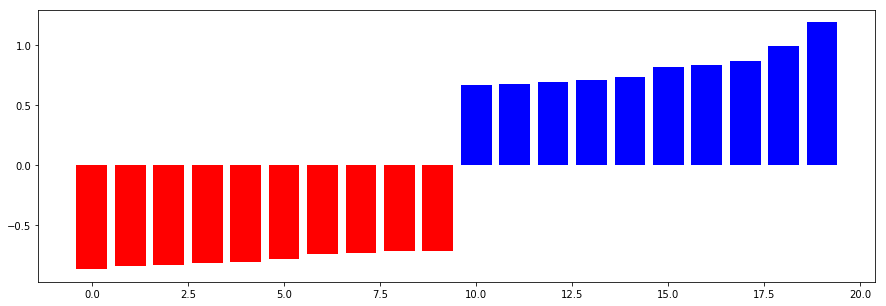

In [16]:
# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(XCopy)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [17]:
#The second model uses Lasso regression but changes the cost to 0.05.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=0.05, class_weight=None, random_state=2) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[27 13]
 [11 43]]
Accuracy (1-Fold) 0.7446808510638298
Accuracy (10-Fold): 0.70 (+/- 0.09)


IndexError: index 272 is out of bounds for axis 1 with size 264

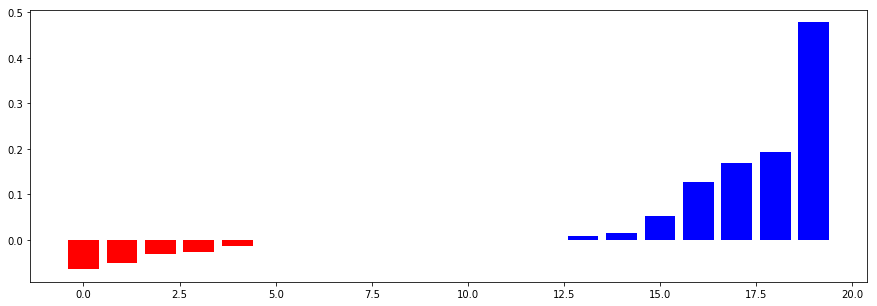

In [18]:
# Graph the columns in terms of prediction weight
#cv = CountVectorizer()
#cv.fit(XCopy)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [19]:
#Our third model will use Ridge regression which also adds a different penalty term. Through trial and error the first cost penalty (C) we will use a cost of 1.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 42))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[27 13]
 [20 34]]
Accuracy (1-Fold) 0.648936170212766
Accuracy (10-Fold): 0.68 (+/- 1.47)


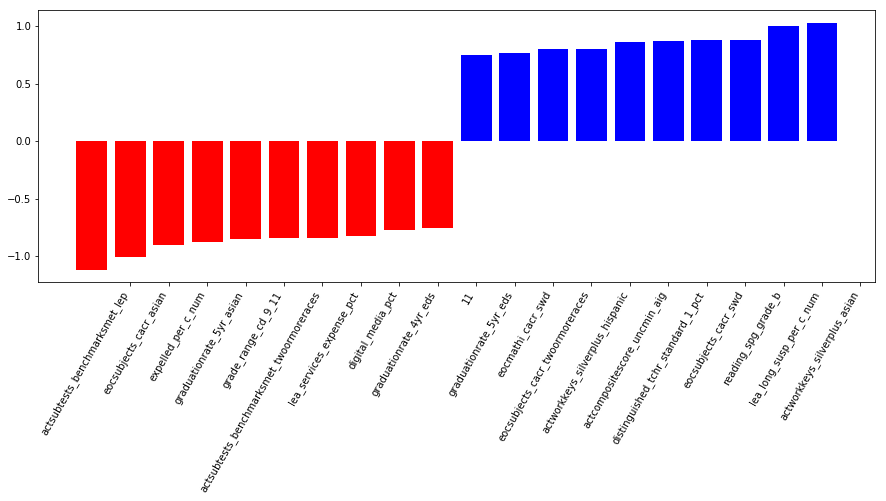

In [20]:
# Graph the columns in terms of prediction weight
#cv = CountVectorizer()
#cv.fit(XCopy)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features=10)

In [21]:
#The fourth model uses Ridge regression but changes the cost to 0.05.
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight=None, random_state=42) # get object
    
# train the reusable logisitc regression model on the training data
lr_clf.fit(xTrain, yTrain)  # train object
y_hat = lr_clf.predict(xTest) # get test set precitions
# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(yTest,y_hat)
conf = mt.confusion_matrix(yTest,y_hat)
print("confusion matrix\n",conf)
print("Accuracy (1-Fold)", acc )
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
scores = cross_val_score(lr_clf, X, y, cv=cv_object)
print("Accuracy (10-Fold): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# The code above provides accuracy mean from all 10 iterations and their standard
# deviation.

confusion matrix
 [[29 11]
 [14 40]]
Accuracy (1-Fold) 0.7340425531914894
Accuracy (10-Fold): 0.68 (+/- 0.09)


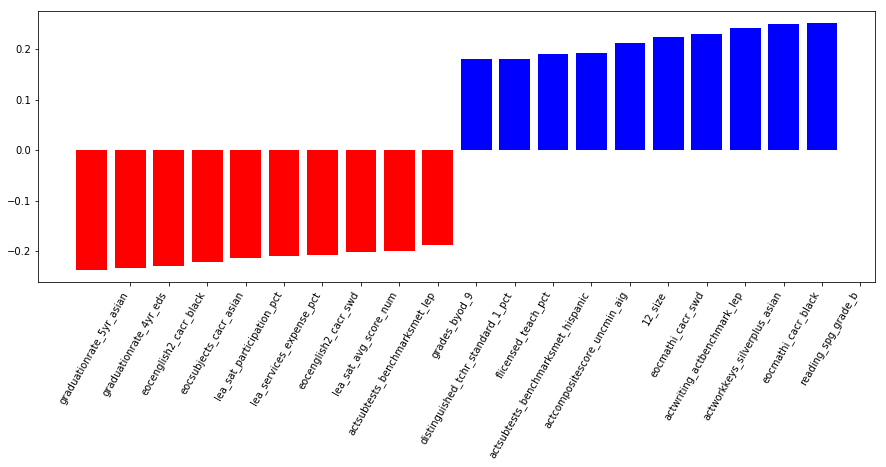

In [22]:
# Graph the columns in terms of prediction weight
#cv = CountVectorizer()
#cv.fit(XCopy)

plot_coefficients(lr_clf, cv.get_feature_names(), top_features = 10)

## Support Vector Machines

### Linear Regression Features
For comparison against the two models, build a model with the attributes used for the linear regression model

In [23]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

In [24]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrainLR, yTrainLR)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 21:36:27.958886
Wall time: 2.38 s
Best parameters set found on development set:

{'C': 1}

gridLinear scores on development set:

0.699 (+/-0.108) for {'C': 1}
0.697 (+/-0.095) for {'C': 10}
0.697 (+/-0.100) for {'C': 100}
0.697 (+/-0.100) for {'C': 1000}



In [25]:
# Set model to best values found
cls = SVC(C = bestValues['C'], kernel = 'linear')

# Train
cls.fit(xTrainLR, yTrainLR)

# Predict test values
yhat = cls.predict(xTestLR)

# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

[[26 14]
 [23 31]]
              precision    recall  f1-score   support

           0       0.53      0.65      0.58        40
           1       0.69      0.57      0.63        54

   micro avg       0.61      0.61      0.61        94
   macro avg       0.61      0.61      0.61        94
weighted avg       0.62      0.61      0.61        94



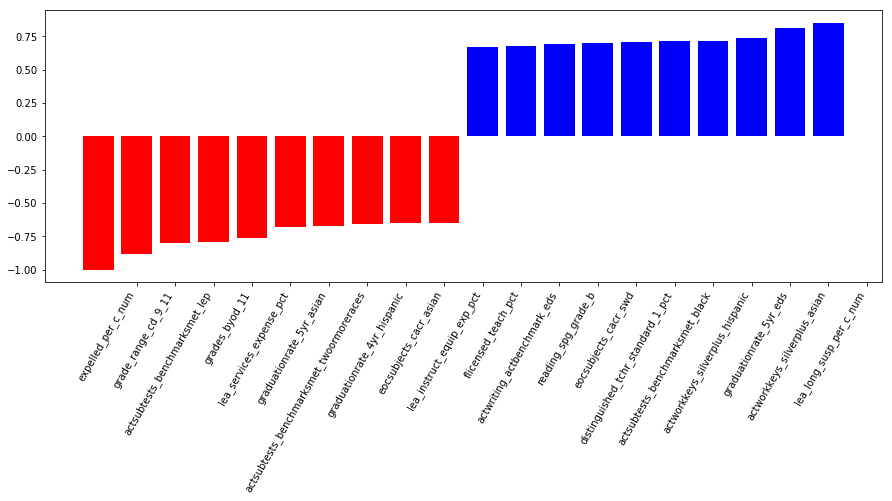

In [26]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

### ANOVA Feature Selection
Using the ANOVA F-value to determine which columns have the greatest proportion of variance, we select the top 10% to be used in our model. The F-value tells us which column(s) help to explain the greatest amount of variance in the target variable. The columns with the highest proportion allows the model to solve for the greatest separation on attributes for classification.

In [27]:
# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct')

dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Subset the data to exclude the target variable
maxCols = dfPublicHS.shape[1]
X = dfPublicHS.iloc[:,0:maxCols-2]

# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

Split the resulting dataset into 80% for training and 20% for testing. After we split the training data, we then scale the data so that each column contributes equal weight to the model. A column with a range of 1 and a column with a range of 10,000 will be highly biased by the column with a range of 10,000. Scaling the columns puts each column on an equal range. We use fit to calculate the mean and standard deviation for the train data set. We use the mean and standard deviation of the train data on the test data so that information isn't biased by data that we shouldn't know about.

In [28]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X.astype(np.float), y, test_size = 0.2, random_state = 42)

# Scale data after splitting out test data
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

Here we create a range of values to test the model against to determine which parameters provide the best result.

In [29]:
# Set parameter turning values and create a grid of models to run
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=[1,10,100,1000])

gridRBF = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

Run the models and show results

In [30]:
# Train SVM model on the each different parameter value
print("Training started at: {}".format(datetime.now().time()))
%time gridRBF.fit(xTrain, yTrain)

bestValues = gridRBF.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridRBF scores on development set:")
print()
means = gridRBF.cv_results_['mean_test_score']
stds = gridRBF.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridRBF.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 21:36:53.809691
Wall time: 8.68 s
Best parameters set found on development set:

{'C': 1, 'gamma': 0.001}

gridRBF scores on development set:

0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-09}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-08}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-07}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-06}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1e-05}
0.663 (+/-0.118) for {'C': 1, 'gamma': 0.0001}
0.694 (+/-0.136) for {'C': 1, 'gamma': 0.001}
0.686 (+/-0.086) for {'C': 1, 'gamma': 0.01}
0.659 (+/-0.164) for {'C': 1, 'gamma': 0.1}
0.583 (+/-0.080) for {'C': 1, 'gamma': 1.0}
0.519 (+/-0.013) for {'C': 1, 'gamma': 10.0}
0.519 (+/-0.013) for {'C': 1, 'gamma': 100.0}
0.519 (+/-0.013) for {'C': 1, 'gamma': 1000.0}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-09}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-08}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-07}
0.519 (+/-0.013) for {'C': 10, 'gamma': 1e-06}
0.663 (+/-0.118) for {'C': 10, 'gamma': 1e-05}
0.681 (

Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [31]:
# Set model to best values found
cls = SVC(C = bestValues['C'], gamma = bestValues['gamma'])

# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

[[28 12]
 [15 39]]
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        40
           1       0.76      0.72      0.74        54

   micro avg       0.71      0.71      0.71        94
   macro avg       0.71      0.71      0.71        94
weighted avg       0.72      0.71      0.71        94



Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

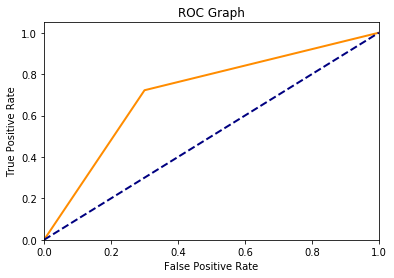

In [32]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

Here we create a range of values to test the model against to determine which parameters provide the best result.

In [34]:
param_grid = dict(C=[1,10,100,1000])
gridLinear = GridSearchCV(SVC(), param_grid=param_grid, iid = False, cv=10)

In [35]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time gridLinear.fit(xTrain, yTrain)

bestValues = gridLinear.best_params_

print("Best parameters set found on development set:")
print()
print(bestValues)
print()
print("gridLinear scores on development set:")
print()
means = gridLinear.cv_results_['mean_test_score']
stds = gridLinear.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gridLinear.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 21:37:16.552385
Wall time: 691 ms
Best parameters set found on development set:

{'C': 1}

gridLinear scores on development set:

0.678 (+/-0.082) for {'C': 1}
0.632 (+/-0.151) for {'C': 10}
0.632 (+/-0.183) for {'C': 100}
0.592 (+/-0.202) for {'C': 1000}



Using the best parameters found from the grid search above, test our model against data that it hasn't seen before.

In [36]:
cls = SVC(C = bestValues['C'], kernel = 'linear')

In [37]:
# Train
cls.fit(xTrain, yTrain)

# Predict test values
yhat = cls.predict(xTest)

# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

[[27 13]
 [11 43]]
              precision    recall  f1-score   support

           0       0.71      0.68      0.69        40
           1       0.77      0.80      0.78        54

   micro avg       0.74      0.74      0.74        94
   macro avg       0.74      0.74      0.74        94
weighted avg       0.74      0.74      0.74        94



Plot an ROC curve of the results. An ROC curve helps show the trade offs between true-negatives and false-positives. For instance, if we were trying to predict whether someone has a deadly illness then we would want to select a model that gives the fewest number of true-negatives. However, in our cause, it's acceptable to have a higher false-positive rate since we are only exploring attributes that could contribute to higher levels of students enrolling in postsecondary education.

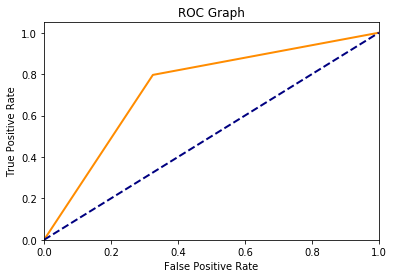

In [38]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

### Most influential Support Vectors
The graph below helps us determine which attributes have the most impact on the boundary between support vectors. This gives us some indication of what attributes might help increase the number of students enrolled in postsecondary education.

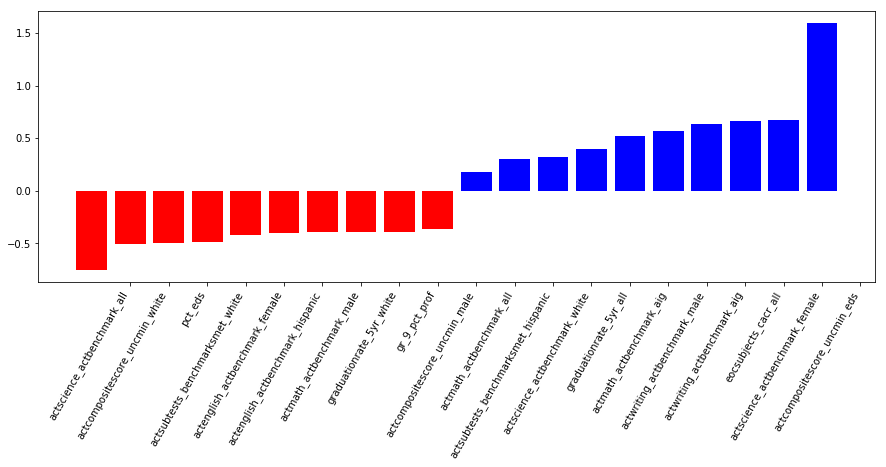

In [39]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer()
cv.fit(X)

plot_coefficients(cls, cv.get_feature_names(), top_features = 10)

In [ ]:
# Cool Plot
# http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#example-svm-plot-separating-hyperplane-py

## Interpret Feature Importance (30 points)

<span style="color: blue">Use the weights from logistic regression to interpret the importance of different features for the classification task. <b>Explain your interpretation in detail.</b>Why do you think some variables are more important?

## Model Advantages (10 points)
<span style="color: blue">Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</span>

## Interpret Support Vectors (10 points)
<span style="color:blue">Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

In [ ]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,X.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out